In [1]:
import pandas as pd
import pynbody
import numpy as np
import h5py
import pynbody.plot.sph as sph
from pynbody import units
from pynbody.analysis import profile
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors


In [2]:
import sys
sys.path.append('/home/vadilloj/MAP2023/Vadillo-Justice-League-Code')
from Runnable_Modules import Base as base, IonUtils as ions, TrackingUtils as tracking


from Runnable_Modules.IonUtils import HI_factor, OVI_factor
from Runnable_Modules.Base import simulations

In [121]:
import importlib
importlib.reload(base)
importlib.reload(tracking)

<module 'Runnable_Modules.TrackingUtils' from '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/Runnable_Modules/TrackingUtils.py'>

In [ ]:
subsims['

In [74]:
def getHaloChars(h1, subsims,edge):

    def getMassProfiles(subsnap, mass, ranges, nbins, totalMass, binAreas):
        mass, bins = np.histogram(subsnap['r'], bins = nbins, weights = subsnap[mass], range= ranges)
        fraction = mass/totalMass
        density = mass/binAreas
        return fraction, density
    nbins = 100   
    
    ranges = (0.1, edge)

    total_mass, bins = np.histogram(h1.g['r'], bins = nbins, weights = h1.g['mass'], range= ranges)
    total_OVI, bins = np.histogram(h1.g['r'], bins = nbins, weights = h1.g['OVI_mass'], range= ranges)
    total_HI, bins = np.histogram(h1.g['r'], bins = nbins, weights = h1.g['HI_mass'], range= ranges)
    bin_areas = np.zeros(nbins)
    for binNum in range(nbins):
        outer_shell = (4/3)*np.pi*(bins[binNum+1]**3)
        inner_shell = (4/3)*np.pi*(bins[binNum]**3)
        bin_areas[binNum] = outer_shell - inner_shell
    
    HI_Ratios,OVI_Ratios, Mass_Ratios  = {}, {}, {}
    HI_Density, OVI_Density,Mass_Density= {}, {}, {}
    rmin = str(ranges[0])+ " kpc"
    rmax = str(ranges[1])+ " kpc"

    
    profiles = {}
    # HaloCharachteristics['all_gas']['profile'] = allProf
    ##add a halo charachteristic of all of the gas to the halo Halo CHarachteristics array
    for halo in subsims:
        haloProf = profile.Profile(subsims[halo],rmin = rmin, nbins = nbins, rmax = rmax, ndim=3)
    
        HI_Ratios[halo], HI_Density[halo] = getMassProfiles(subsims[halo],"HI_mass", ranges, nbins, total_HI, bin_areas)
        OVI_Ratios[halo], OVI_Density[halo]= getMassProfiles(subsims[halo],"OVI_mass", ranges, nbins, total_OVI, bin_areas)
        Mass_Ratios[halo], Mass_Density[halo] = getMassProfiles(subsims[halo],"mass", ranges, nbins, total_mass, bin_areas)
        profiles[halo] = haloProf
    indexes = list(subsims.keys())
    indexes.insert(0, indexes.pop(indexes.index('local')))
    
    HaloChars = pd.DataFrame(pd.Series(profiles), index = indexes, columns  = ['profiles'])##data frame to store halo data
    HaloChars['Mass_Ratios']  = Mass_Ratios
    HaloChars['HI_Ratios']  = HI_Ratios
    HaloChars['OVI_Ratios']  = OVI_Ratios
    HaloChars['Mass_Density']  = Mass_Density
    HaloChars['HI_Density']  = HI_Density
    HaloChars['OVI_Density']  = OVI_Density

    rbins = (bins[0:-1] + bins[1:])/2
    return HaloChars, rbins

In [84]:
def makeStackplot(HaloChars, column , ax, rbins, cmapN, local_color = 'black',dwarfColor = 'white',cmap_end = 0.8):

    labels = list(HaloChars.index)
    nSources  = len(labels)

    cmap = mpl.colormaps[cmapN]
    segmentedCmap = cmap(np.linspace(0.2,cmap_end, nSources))
    segmentedCmap[0] = colors.to_rgba(local_color)
    segmentedCmap[-1] = colors.to_rgba(dwarfColor)
    values = []
    for label in labels:
        values.append(HaloChars[column][label])
    ax.stackplot(rbins, values, labels = labels, colors = segmentedCmap)

In [100]:
def make_all_stacks(sHaloChars, filename,edge ):
    plots_filepath  = '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/Mass Fractions Divided By Source/Plots/'
    rows = 3
    cols = 2
    cmaps = ['bone', 'BuPu_r', 'YlOrRd_r']
    cmap_end = [0.8,0.8,0.8]
    ions = ["Mass", "HI", "OVI"]
    values = ["Density", "Ratios"]
    localC = ['black','Indigo', 'maroon']  
    smallsColors= ['burlywood', 'lightskyblue', 'lightcoral']
    yranges = [(10**1, 10**7), (10**-3.5, 10**3.5), (10**-3, 10**-1)]
    fig, axs = plt.subplots(rows,cols, figsize = (11,13))
    for row in (range(rows)):
        for col in range(cols):
            ax = axs[row, col]
            Hcolumn = ions[row] + '_' + values[col]
            makeStackplot(sHaloChars, Hcolumn, ax, rbins,
                          cmapN = cmaps[row],local_color = localC[row],dwarfColor =smallsColors[row], cmap_end = cmap_end[row])
            
            ax.set_xlim(1,edge)
    
            if (col == 0):
                ax.set_yscale("log")
                ax.set_title(ions[row] + " Log Density(Msol/kpc**3) Profile  divided by source")
                ax.set_ylabel('Log '+ ions[row]+ ' mass')
                ax.legend(loc = 'upper right')
                median = np.median(sHaloChars[Hcolumn]['local'])
                ax.set_ylim(yranges[row])
                

                    
                    
            else:
                ax.axhline(1,color = 'black', linestyle = '--')
                ax.set_title("fraction of total " +ions[row] +" divided by source")
                ax.set_ylabel('fraction of '+ ions[row]+ ' mass')
                ax.legend(loc = 'lower left')
                
    
    
    fig.supxlabel('radius (kpc)')
    name = filename + ' Mass Divided by Source'
    fig.suptitle(name, fontsize = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    fig.savefig(plots_filepath+ name + '.png')


SimArray(0.)

,t,redshift,a,haloid,z0haloid,mstar,mgas,mass,Rvir,gas_rho,...,outflow_23,inflow_temp_23,outflow_temp_23,inflow_91,outflow_91,inflow_temp_91,outflow_temp_91,sim,key,Hdist
time,,,,,,,,,,,,,,,,,,,,,
13.800797,13.800797,5.299428e-11,1.0,2,2,2.268773e+09,8.252345e+09,9.575866e+10,95.146148,[ 4023762.91702522 126840.83423835 54424....,...,0.456047,15363.511326,38446.496389,-0.000273,0.042408,24099.185653,23684.923082,h148,h148_2,504.170554
13.800797,13.800797,5.299428e-11,1.0,3,3,1.502171e+09,2.975036e+09,4.697010e+10,76.051992,[3.46847585e+04 5.19141181e+06 1.13067354e+05 ...,...,0.152226,17219.020137,33047.679894,-0.000695,0.011663,17575.500434,23926.035774,h148,h148_3,291.305391
13.800797,13.800797,5.299428e-11,1.0,4,4,4.317847e+08,9.706413e+08,3.248971e+10,67.257466,[7120007.63922593 269965.40512414 9557.804...,...,0.063139,18398.471344,33268.395814,-0.000039,0.005368,62860.398438,18839.048065,h148,h148_4,173.039024
13.800797,13.800797,5.299428e-11,1.0,6,6,3.315968e+08,1.010160e+09,2.869601e+10,64.527622,[3.80445945e+06 2.76299551e+05 2.77913218e+05 ...,...,0.104018,19798.461485,33827.872952,-0.000851,0.002218,20912.136058,26878.758550,h148,h148_6,329.096623
13.800797,13.800797,5.299428e-11,1.0,7,7,2.359537e+08,1.596514e+08,1.561130e+10,52.678621,[3399758.56285417 53195.38848863 4793572.773...,...,0.013406,42228.990382,43249.799751,0.000000,0.000273,NaN,18808.567349,h148,h148_7,340.276764


In [169]:
def findMassRatios(simulations,filename, HaloChars):

    mass_inhalo = {}
    satmass = {}
    mean_vr ={}
    pos = {}

    smallMass,smallOVI, smallHI = 0, 0 , 0
    haloMass,haloOVI, haloHI = 0, 0 , 0
    for haloKey in list(simulations['Halo keys'][filename]):
        subsnap = h[int(haloKey.split('_')[1])]
        simMass = np.sum(subsnap['mass'])
        
        halo = "h"+(haloKey.split('_')[1]) 
        satmass[halo] = simMass
        mean_vr[halo] = np.mean(subsnap['vr'])
        pos[halo] = np.mean(subsnap['pos'], axis = 0)

        haloMass+= simMass
        if halo in list(HaloChars.index):
            mass_inhalo[halo] = np.sum(HaloChars["profiles"][halo]["mass"])/simMass
        else:
            smallMass+= simMass
    mass_inhalo["Dwarf Sattelites"] = np.sum(HaloChars["profiles"]["Dwarf Sattelites"]["mass"])/smallMass
    satmass["Dwarf Sattelites"]  = smallMass
    mean_vr["Dwarf Sattelites"],mean_vr["halos"] = 0, 0
    pos["Dwarf Sattelites"],pos["halos"] = 0, 0
    satmass['halos'] = haloMass
    mass_inhalo['halos'] =           np.sum(HaloChars["profiles"]['halos']["mass"] )/haloMass

    HaloChars['MVir'] = satmass
    HaloChars['pos'] = pos
    HaloChars['mean vr'] = mean_vr
    HaloChars['Mvir/Mtotal'] = mass_inhalo
    return HaloChars
    
    

/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/pynbody/halo/__init__.py:274: RuntimeWarning: Accessing multiple halos may be more efficient if you call load_all() on the halo catalogue
  warnings.warn("Accessing multiple halos may be more efficient if you call load_all() on the "
pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor
/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/pynbody/halo/__init__.py:274: RuntimeWarning: Accessing multiple halos may be more efficient if you call load_all() on the halo catalogue
  warnings.warn("Accessing multiple halos may be more efficient if you call load_all() on the "


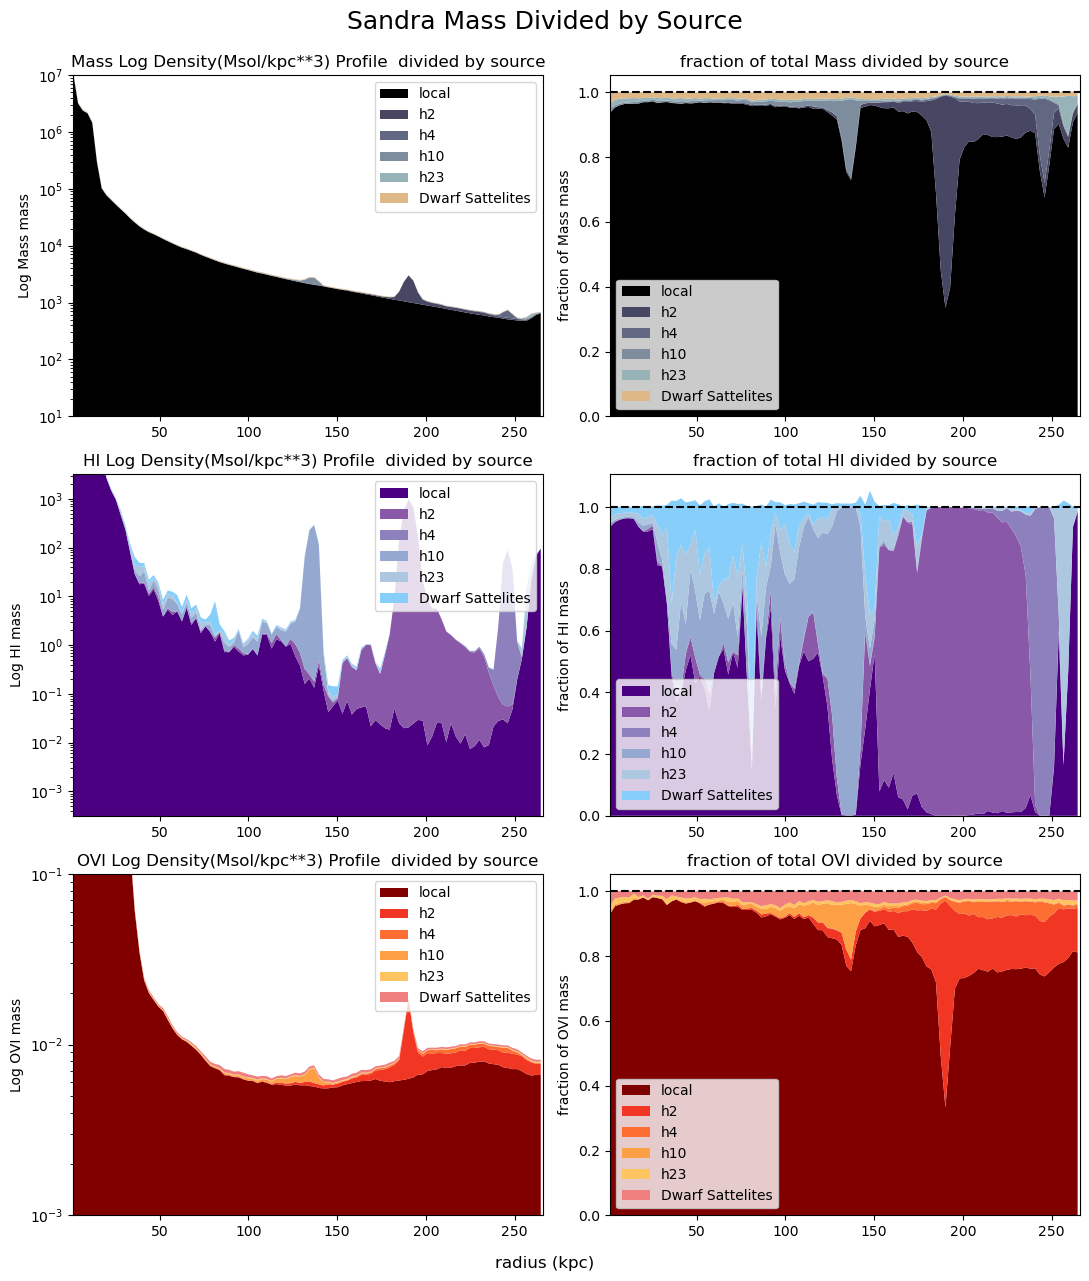

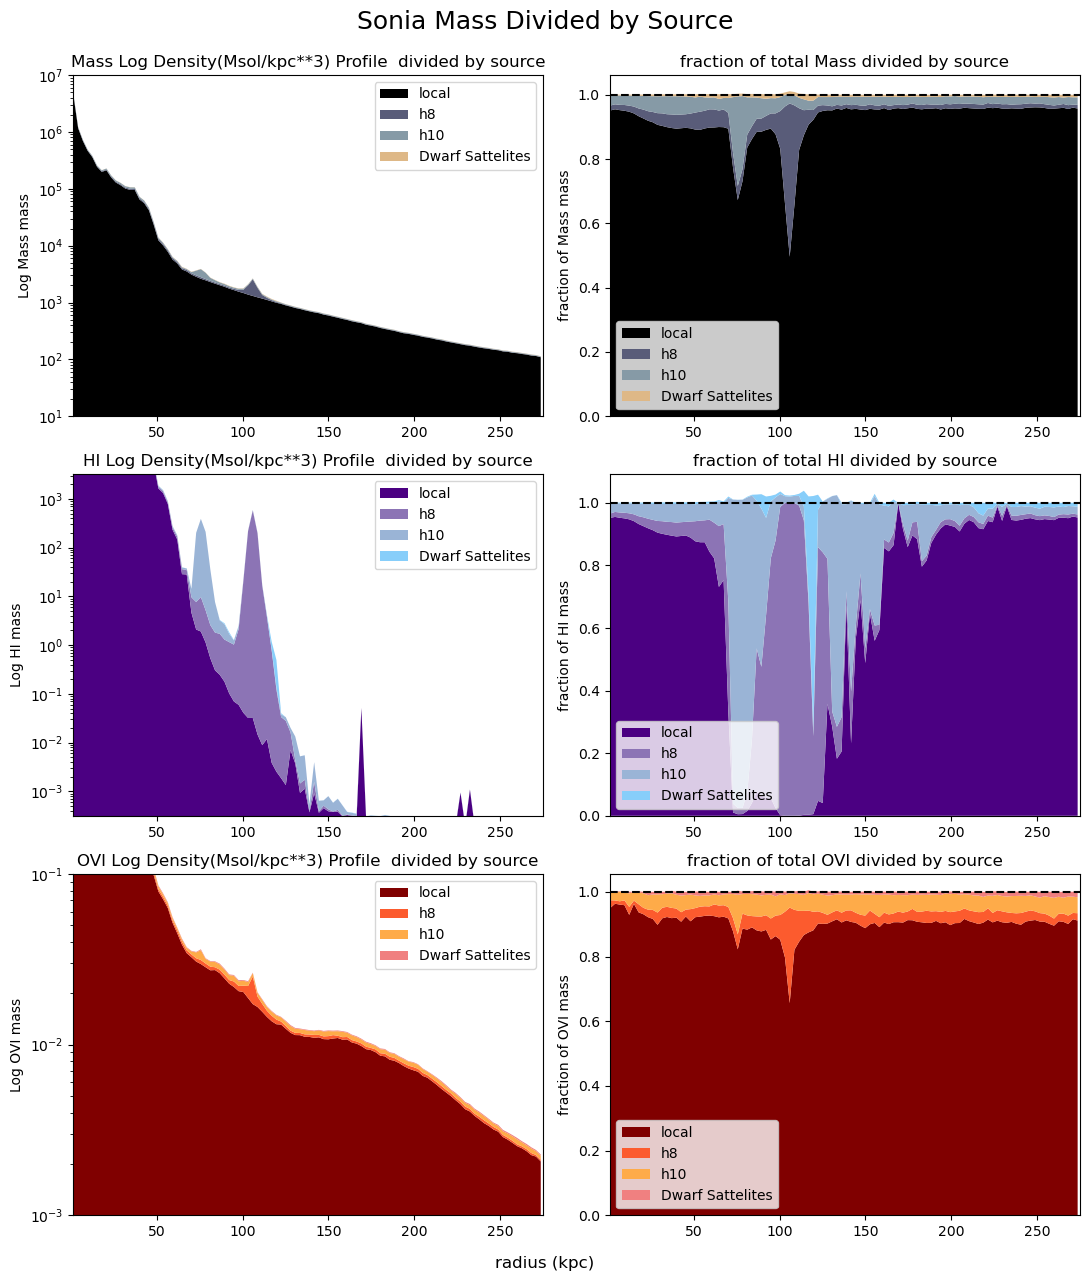

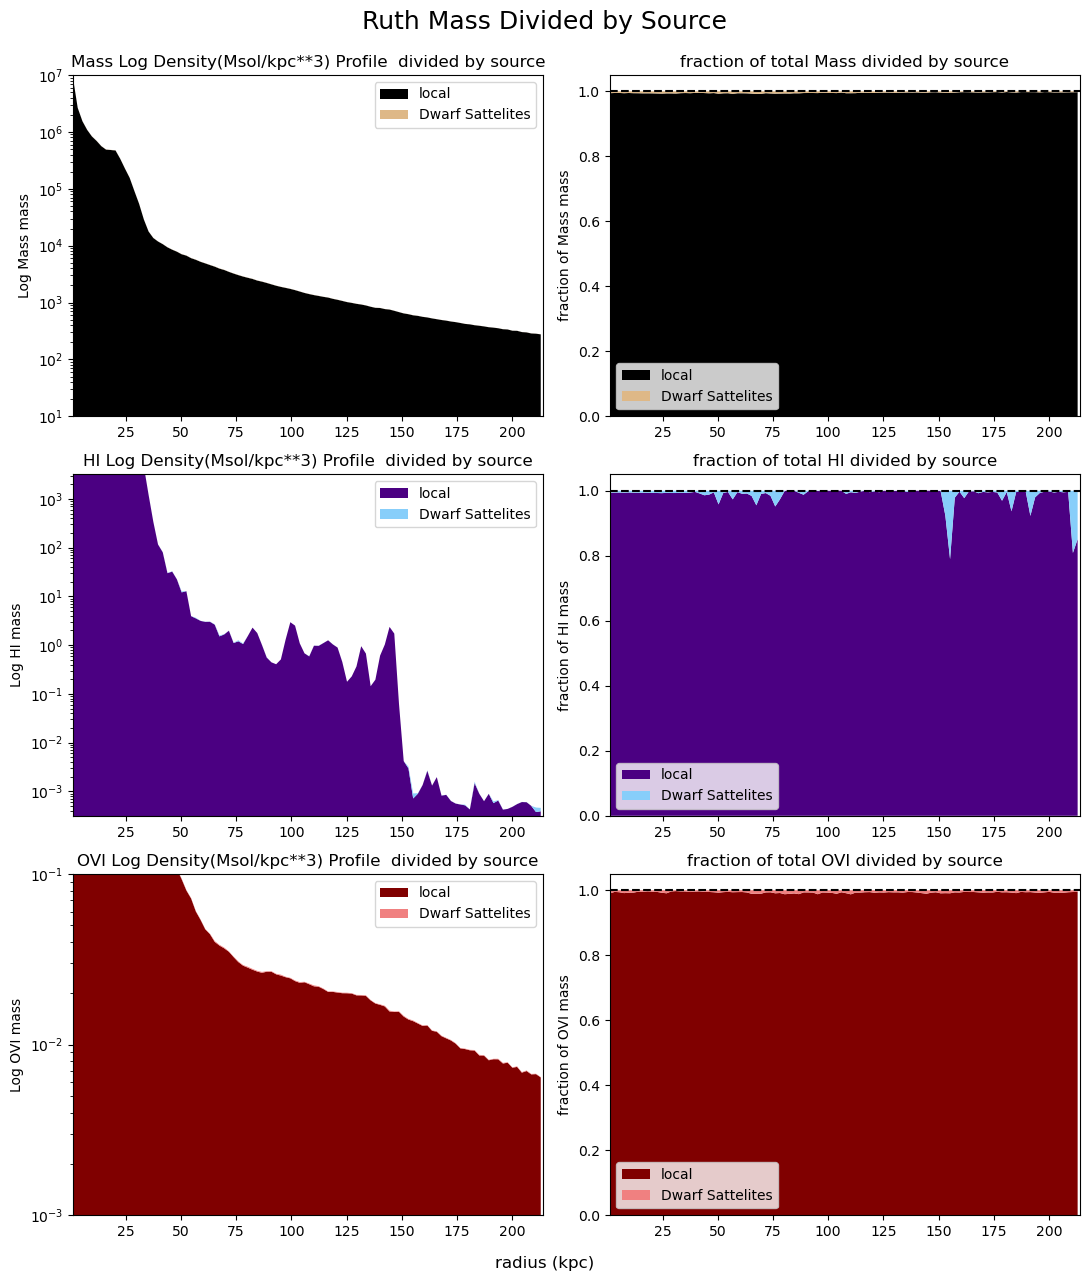

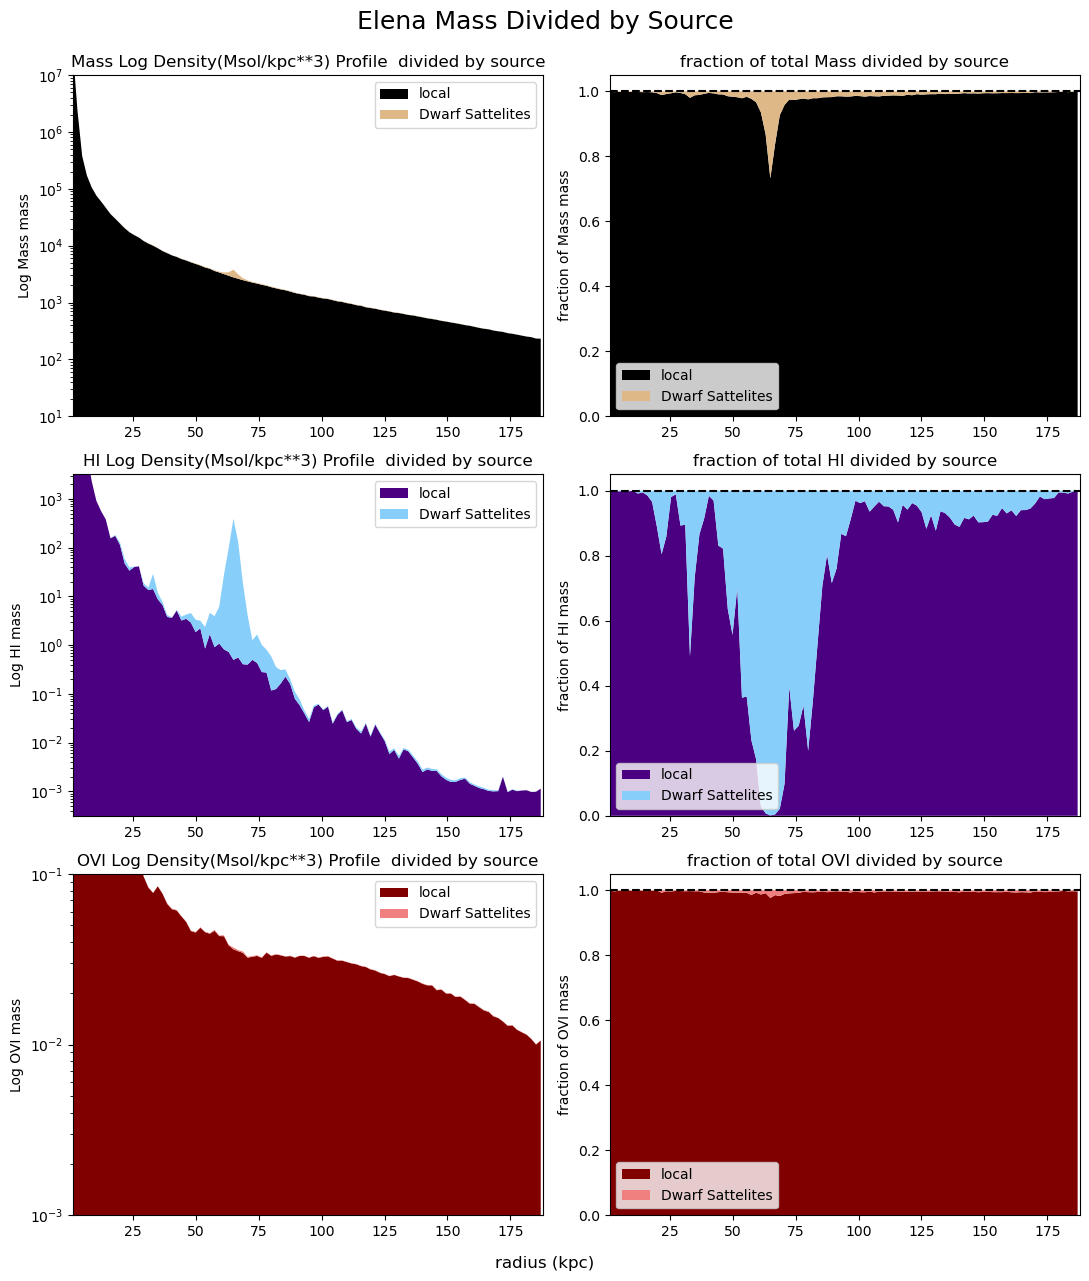

In [170]:
data_filepath  = '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/Mass Fractions Divided By Source/Data/'
filenames  = ['Sandra', 'Sonia', 'Ruth', 'Elena']
for filename in filenames:
    s, h1, h = base.load_in_sim(filename, return_h = True)
    ions.calculate_gas_mass(s)
    ions.calculate_gas_rhos(s)
    
    tracking.find_halo_keys(simulations) ## to the base "simulations"  data structure adds the halo keys to each sim.
    subsims = tracking.find_halo_particles(h1, simulations, filename, groupSmalls = True)##returns a dictionary of subsims for all halos in the simulations, 
    #accesible by their halo number (ie h2, h10 etc)
    edge = int(np.max(h1.g['r']))
    HaloChars, rbins = getHaloChars(h1, subsims,edge)
    HaloChars = findMassRatios(simulations,filename, HaloChars)
    HaloChars= HaloChars.drop(columns=['profiles'])
    
    sHaloChars = HaloChars.drop('halos')
    
    data_name = data_filepath + filename +"Halo Charachteristics.csv"
    sHaloChars.to_csv(data_name)
    make_all_stacks(sHaloChars, filename,edge )

In [96]:
def readInData(filename):
    data_name = data_filepath + filename +"Halo Charachteristics.csv"
    return(pd.read_csv(data_name, index_col = 0))

In [171]:
readInData("Sandra")

,Mass_Ratios,HI_Ratios,OVI_Ratios,Mass_Density,HI_Density,OVI_Density,MVir,pos,mean vr,Mvir/Mtotal
local,[0.93757698 0.9532029 0.96004573 0.9639219 0...,[9.36657914e-01 9.51874816e-01 9.58684512e-01 ...,[0.93163445 0.95437419 0.9599199 0.96343693 0...,[1.02310777e+07 3.15563821e+06 2.36823222e+06 ...,[3.18935454e+06 1.20449975e+06 9.60858390e+05 ...,[1.61998173e+03 4.05809754e+02 2.51446822e+02 ...,NaN,NaN,NaN,NaN
h2,[3.05605464e-04 2.34136724e-04 2.57835900e-04 ...,[2.53164502e-04 2.23480577e-04 3.07953338e-04 ...,[1.76107119e-04 1.31299848e-04 3.35948911e-04 ...,[3.33484431e+03 7.75124361e+02 6.36027294e+02 ...,[8.62034413e+02 2.82791702e+02 3.08651642e+02 ...,[3.06225596e-01 5.58300501e-02 8.80003489e-02 ...,9.575866e+10,[ -61.63786506 -163.45550937 81.86031667],11.184429,0.110598
h4,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[0.00000000e+000 0.00000000e+000 0.00000000e+0...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[0.00000000e+000 0.00000000e+000 0.00000000e+0...,3.248971e+10,[ 65.87879583 -236.70811067 6.07273264],41.243454,0.042505
h10,[0.01214251 0.0065839 0.00473655 0.00368262 0...,[1.20739837e-02 6.69627405e-03 4.99786857e-03 ...,[0.00996849 0.0063755 0.00438482 0.00502979 0...,[1.32502133e+05 2.17964169e+04 1.16840781e+04 ...,[4.11123573e+04 8.47344660e+03 5.00920156e+03 ...,[1.73338034e+01 2.71092763e+00 1.14858357e+00 ...,1.055766e+10,[ -24.40274325 -133.72355108 -6.30891049],54.050569,0.200235
h23,[0.01586279 0.0170318 0.01515011 0.01369445 0...,[1.59606018e-02 1.74718513e-02 1.59558734e-02 ...,[0.01653715 0.01764276 0.01642835 0.01451627 0...,[1.73098752e+05 5.63848381e+04 3.73721623e+04 ...,[5.43464344e+04 2.21088321e+04 1.59920544e+04 ...,[2.87557791e+01 7.50188225e+00 4.30333411e+00 ...,3.333412e+09,[ 181.42868157 90.71569332 -160.91334707],-26.909872,0.424464
Dwarf Sattelites,[0.03553676 0.02409431 0.02101648 0.01950828 0...,[3.62546314e-02 2.49709036e-02 2.13440325e-02 ...,[0.04403903 0.02305485 0.02020963 0.0189079 0...,[3.87786104e+05 7.97657329e+04 5.18432579e+04 ...,[1.23448349e+05 3.15981121e+04 2.13924314e+04 ...,[7.65777015e+01 9.80315816e+00 5.29382349e+00 ...,6.391948e+10,0,0.000000,0.041663


In [85]:
HaloChars, rbins = getHaloChars(h1, subsims,edge)

# findMassRatios(simulations, filename, HaloChars)
# print(HaloChars)

# sHaloChars = HaloChars.drop('halos')

# data_name = data_filepath + filename +"Halo Charachteristics.csv"
# sHaloChars.to_csv(data_name)
make_all_stacks(sHaloChars, filename,edge )

/tmp/ipykernel_8362/2331304600.py:5: RuntimeWarning: invalid value encountered in divide
  fraction = mass/totalMass


NameError: name 'yranges' is not defined

In [ ]:
subsims = tracking.find_halo_particles(h1, simulations, filename, groupSmalls = True)##returns a dictionary of subsims for all halos in the simulations, 

In [47]:
s[2]

<IndexedSubSnap "/home/vadilloj/MAP2023/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200crit_h148/h148.cosmo50PLK.3072g3HbwK1BH.004096:indexed" len=1>

In [497]:
np.sum(subsims['h249']['mass']) < 10**9

SimArray(True)

In [494]:
HaloChars

,Mass_Ratios,HI_Ratios,OVI_Ratios,Mass_Density,HI_Density,OVI_Density
local,"[0.9375769756535733, 0.953202904849825, 0.9600...","[0.9366579142685311, 0.9518748160776909, 0.958...","[0.9316344504687396, 0.9543741916449991, 0.959...","[10231077.668726847, 3155638.2073895275, 23682...","[3189354.542331212, 1204499.7493546424, 960858...","[1619.981725233334, 405.8097542615653, 251.446..."
h2,"[0.00030560546406010303, 0.0002341367240614409...","[0.00025316450229026196, 0.0002234805774582983...","[0.0001761071190412844, 0.00013129984775434373...","[3334.8443060972777, 775.1243606603425, 636.02...","[862.0344130300964, 282.7917022149484, 308.651...","[0.3062255956580738, 0.05583005011894839, 0.08..."
h4,"[0.0, 0.0, 0.0, 0.0, 3.816739795564414e-06, 8....","[0.0, 0.0, 0.0, 0.0, 3.5785359972006313e-06, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 5.737834675216138, 2.7161...","[0.0, 0.0, 0.0, 0.0, 2.4100673578073875, 1.736...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
h6,"[0.011055449781172752, 0.0021505931866588786, ...","[0.011455060996212874, 0.002255395888643024, 0...","[0.009662954186267192, 0.0014274526135225447, ...","[120639.870977037, 7119.674094406534, 1077.699...","[39004.90271251646, 2853.971695311966, 396.418...","[16.802522905463388, 0.6069675808344647, 0.047..."
h7,"[0.004949894881661567, 0.002542396511280525, 0...","[0.0046819563360971, 0.0026939034292107413, 0....","[0.006798965518356862, 0.002298590960748604, 0...","[54014.50792988014, 8416.76365914417, 4375.348...","[15942.232996759478, 3408.857919616514, 1892.4...","[11.82244804782396, 0.97738459515701, 0.600953..."
h10,"[0.012142508675581608, 0.006583900468026312, 0...","[0.012073983735477793, 0.006696274053775125, 0...","[0.00996848803207666, 0.006375498213801424, 0....","[132502.13324240939, 21796.416864494244, 11684...","[41112.35733362877, 8473.446595233614, 5009.20...","[17.333803437653415, 2.7109276278503827, 1.148..."
h12,"[0.0019025043038783493, 0.002069881835439179, ...","[0.0020202053777954934, 0.0023256174435709476,...","[0.0014499587395904866, 0.0018172033792081665,...","[20760.609319035288, 6852.47408653513, 4363.74...","[6878.873385856866, 2942.8298559454265, 1824.8...","[2.521275012207981, 0.7726936281550862, 0.2986..."
h23,"[0.01586278684126777, 0.01703179767191091, 0.0...","[0.01596060180032104, 0.017471851268613604, 0....","[0.016537146065254128, 0.017642756825073456, 0...","[173098.75181430945, 56384.838107976255, 37372...","[54346.43435426088, 22108.832084164544, 15992....","[28.755779050191894, 7.501882253688171, 4.3033..."
h27,"[0.009817733836916722, 0.009673178547969149, 0...","[0.010630003025704935, 0.010055083961889474, 0...","[0.013640676775039265, 0.011493918130827148, 0...","[107133.60078660522, 32023.66637529431, 24302....","[36195.550070702695, 12723.67532712121, 10140....","[23.71922494306671, 4.887332592401578, 2.51090..."
h34,"[0.0007619799418719833, 0.0005901698054177551,...","[0.0007311883595720756, 0.0004914510433758734,...","[0.00016937425122990626, 0.0001315648043250292...","[8314.918315767962, 1953.7942838280821, 935.01...","[2489.7231746790526, 621.8807857587047, 345.52...","[0.294518082257988, 0.05594271238683156, 0.122..."
